In [33]:
!pip install category_encoders --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [34]:
from google.colab import files

# Upload CSV file
uploaded = files.upload()

Saving loan_data.csv to loan_data (1).csv


In [35]:
df = pd.read_csv('loan_data.csv')
df.head()

,borrower_id,credit_score,annual_income,employment_length,dti,loan_amount,term,interest_rate,loan_purpose,home_ownership,default_status
0,1001,652,76699,27,38.0%,34532,60m,6.62%,wedding,rent,1
1,1002,729,126127,31,29.9%,49229,36m,7.73%,debt_consolidation,mortgage,1
2,1003,642,101253,11,15.3%,37160,60m,16.25%,wedding,mortgage,1
3,1004,564,125659,26,25.3%,30688,36m,7.98%,wedding,mortgage,1
4,1005,656,124769,9,38.0%,13063,36m,10.55%,medical,mortgage,1


In [36]:
essential_columns = [
    'credit_score',
    'annual_income',
    'employment_length',
    'dti',
    'loan_amount',
    'term',
    'interest_rate',
    'loan_purpose',
    'home_ownership',
    'default_status'  # target variable
]

# Filter dataset
df = df[essential_columns]

# Quick look
df.head()

,credit_score,annual_income,employment_length,dti,loan_amount,term,interest_rate,loan_purpose,home_ownership,default_status
0,652,76699,27,38.0%,34532,60m,6.62%,wedding,rent,1
1,729,126127,31,29.9%,49229,36m,7.73%,debt_consolidation,mortgage,1
2,642,101253,11,15.3%,37160,60m,16.25%,wedding,mortgage,1
3,564,125659,26,25.3%,30688,36m,7.98%,wedding,mortgage,1
4,656,124769,9,38.0%,13063,36m,10.55%,medical,mortgage,1


In [37]:
df['default_status'].value_counts(normalize=True)

,proportion
default_status,
1,0.6722
0,0.3278


In [38]:
# Function to safely convert percentage strings to float
def percent_to_float(x):
    if isinstance(x, str):
        return float(x.strip('%'))
    else:
        return float(x)

# Apply to both columns
df['dti'] = df['dti'].apply(percent_to_float)
df['interest_rate'] = df['interest_rate'].apply(percent_to_float)

# Clean annual_income (remove commas if any)
df['annual_income'] = df['annual_income'].replace(',','', regex=True).astype(float)

# Now ensure numeric columns are float
numeric_cols = ['credit_score', 'annual_income', 'employment_length', 'dti', 'loan_amount', 'interest_rate']
df[numeric_cols] = df[numeric_cols].astype(float)

In [39]:
# Numeric columns → fill with median
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Categorical columns → fill with mode
categorical_cols = ['loan_purpose', 'home_ownership', 'term']
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verify missing values
print("Missing values after imputation:\n", df.isnull().sum())

Missing values after imputation:
 credit_score         0
annual_income        0
employment_length    0
dti                  0
loan_amount          0
term                 0
interest_rate        0
loan_purpose         0
home_ownership       0
default_status       0
dtype: int64


In [40]:
# Handle Outliers (cap 1st & 99th percentile)

for col in numeric_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = np.clip(df[col], lower, upper)


# Income-to-Loan ratio
df['income_to_loan_ratio'] = df['annual_income'] / df['loan_amount']

# Employment length categories
df['employment_length_cat'] = pd.cut(df['employment_length'],
                                     bins=[0,1,3,5,10,50],
                                     labels=['<1yr','1-3yr','3-5yr','5-10yr','>10yr'])


In [41]:
import category_encoders as ce

# List of categorical columns to WOE encode
woe_cols = ['loan_purpose', 'home_ownership', 'term', 'employment_length_cat']

# Initialize WOE encoder (no 'target' in constructor)
woe_encoder = ce.WOEEncoder(cols=woe_cols)

# Fit encoder on X (categorical columns) and y (target)
df_woe = woe_encoder.fit_transform(df[woe_cols], df['default_status'])

# Replace original categorical columns with WOE values
df[woe_cols] = df_woe

**Exploratory Data Analysis (EDA)**

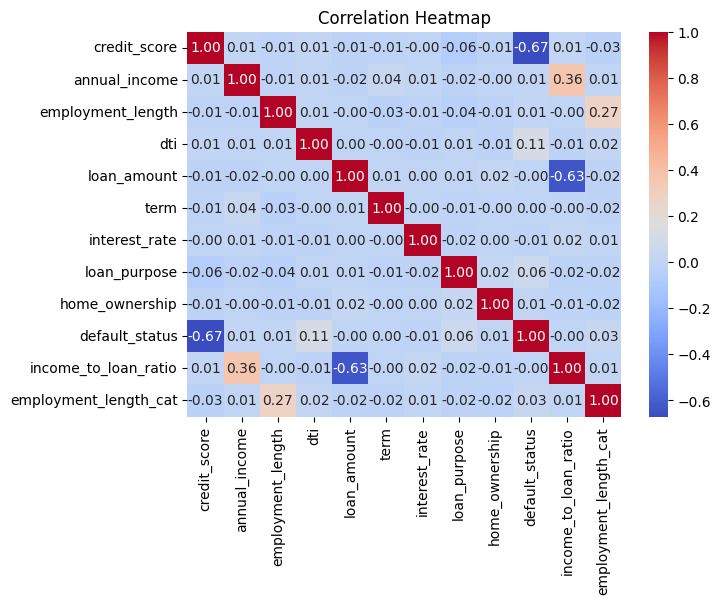

In [42]:
# Basic Statistics
df.describe()

# Correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Default rate by credit score deciles:
 credit_score_decile
0    1.000000
1    1.000000
2    1.000000
3    0.986000
4    0.923695
5    0.674089
6    0.411405
7    0.263889
8    0.245509
9    0.202020
Name: default_status, dtype: float64


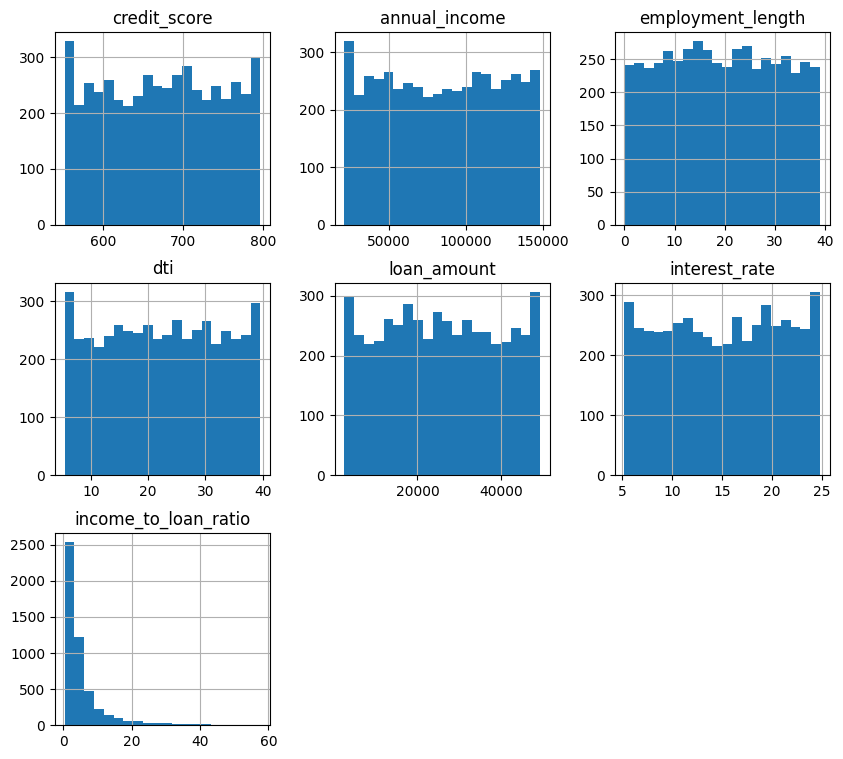

In [43]:
# Default rate by credit_score deciles

df['credit_score_decile'] = pd.qcut(df['credit_score'], 10, labels=False)
decile_default = df.groupby('credit_score_decile')['default_status'].mean()
print("Default rate by credit score deciles:\n", decile_default)

#  Histograms & boxplots for numeric variables
numeric_cols_extended = numeric_cols + ['income_to_loan_ratio']
df[numeric_cols_extended].hist(bins=20, figsize=(10,9))
plt.show()

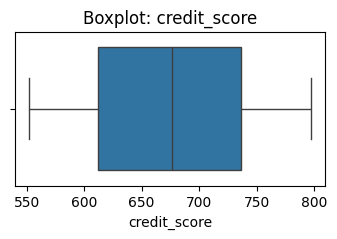

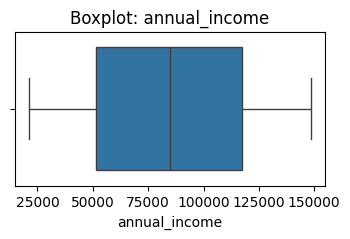

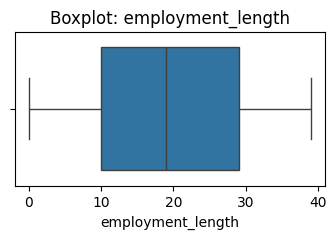

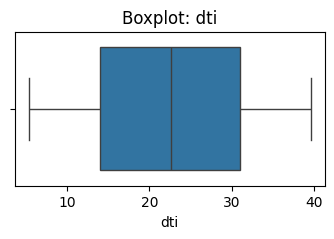

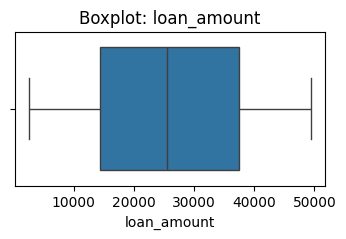

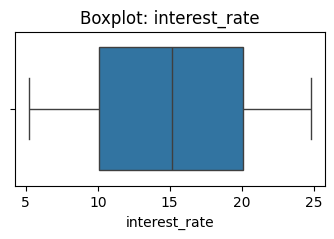

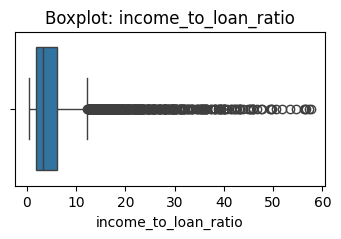

In [44]:
for col in numeric_cols_extended:
    plt.figure(figsize=(4,2))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot: {col}')
    plt.show()

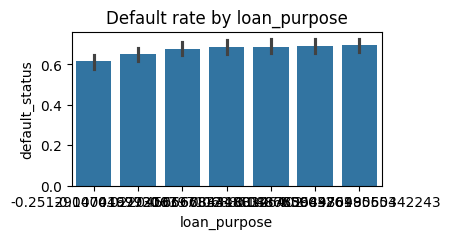

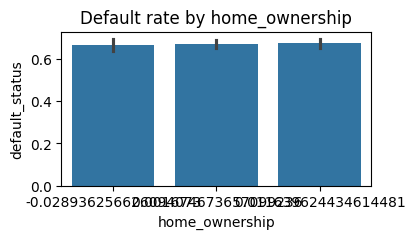

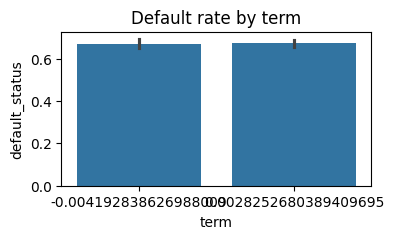

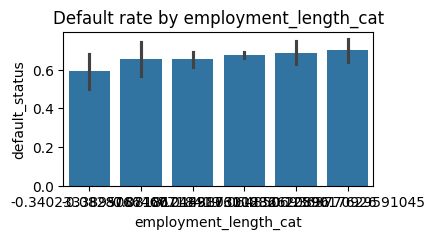

In [45]:
# Barplots for WOE categorical variables vs default rate
for col in woe_cols:
    plt.figure(figsize=(4,2))
    sns.barplot(x=col, y='default_status', data=df)
    plt.title(f'Default rate by {col}')
    plt.show()